# 06. PyTorch Transfer Learning

What is Transfer Learning?

Transfer Learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

* Pretrained model = foundation models

In [1]:
import torch
import torchvision

print(torch.__version__) # want 1.12+
print(torchvision.__version__) # want 0.13+

device = "cuda" if torch.cuda.is_available() else "cpu"

2.3.0+cu121
0.18.0+cu121


Now we have got the versions of torch and torchvision, we are after, let's import the code we have written in previous sections so that we don't have to write it all again.

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 41.32 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


### 1. Get data
We need our pizza, steak, sushi data to build a transfer learning model.

In [3]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classess from the Food101 dataset

# If the image folder doesnot exists, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download")
else:
  print(f"Did not find {image_path} directory, downloading the data...")
  image_path.mkdir(parents = True, exist_ok = True)

  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")
  print("Removed zip file")

Did not find data/pizza_steak_sushi directory, downloading the data...
Unzipping pizza, steak, sushi data...
Removed zip file


In [4]:
# Setup the directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2. Create Datasets and DataLoaders

Now we have got some data, want to turn it into a PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in 05. PyTorch Going Modular.

There's one thing we have to think about when loading: how to **transform** it?

And with `torchvision` 0.13+ there's two ways to do this:
1. Manually created transforms - you define what transform you want your data to go through.
2. Automatically create transforms - the transforms for your data are defined by the model you'd like to use.

Important point: When using a pretrained model, it's important that the data (including your custom data) that you pass through it is **transformed** in the same way that the data the model was trained on.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:

In [5]:
from torchvision import transforms
normalise = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalise
])

In [6]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                test_dir = test_dir,
                                                                                transform = manual_transforms,
                                                                                batch_size = 32,
                                                                          )

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model.

In [7]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights

In [8]:
# get the transform used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                test_dir = test_dir,
                                                                                transform = auto_transforms,
                                                                                batch_size = 32,
                                                                          )


In [10]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78158110b100>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch Hub - https://pytorch.org/hub/ -> Pytorch domain libraries
2. Hugging Face - https://huggingface.co/models -> Huggingface Hub (for plently of different models)
3. Libraries like timm (torch image models)
4. Paperswithcode (for models across different problem spaces/domains)

## 3.1 Which pretrained model should you use?

* Experiment, experiment, experiment!*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed - how fast does it run?
2. Size - How big is the model? # Smaller the size, Higher will the speed of the performance of the pretrained model
3. Performance - How well does it go on your chosen problem (e.g. how well does it classify food images? for Food101 datasets)

Where does the model live?

Is it on device? (like a self-driving car)

Or does it live on a server?

Looking at https://pytorch.org/vision/0.18/models.html#classification

Which model should we choose?

For our case, it looks like **Efficient_Net_B0** is one of the best options in terms performance vs size.

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could - http://www.incompleteideas.net/IncIdeas/BitterLesson.html

### 3.2 Setting up a pretrained model

want to create an instance of a pretrained Efficient_Net_B0 model - https://pytorch.org/vision/0.18/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0

In [11]:
# OLD Method of creating a pretrained modek (prior to torchvision v0.13)
model = torchvision.models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 84.9MB/s]


In [12]:
# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights).to(device)

In [13]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [14]:
# print with torchinfo
from torchinfo import summary

summary(model = model,
        input_size = (1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 1000]       --              True
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1280, 7, 7] --              True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --              True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] 864             True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] 64              True
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --              --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --              True
│    │    └─MBConv (0)                                       [1, 

### 3.4 Freezing the base model and chaging the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundational model and update the output layers to suit your own problems.

In [15]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False

In [16]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, # feature vector coming in
              out_features = len(class_names)) # how many classes do we have?
)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [17]:
summary(model = model,
        input_size = (1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224] [1, 3]          --              Partial
├─Sequential (features)                                      [1, 3, 224, 224] [1, 1280, 7, 7] --              False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224] [1, 32, 112, 112] --              False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224] [1, 32, 112, 112] (864)           False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112] [1, 32, 112, 112] (64)            False
│    │    └─SiLU (2)                                         [1, 32, 112, 112] [1, 32, 112, 112] --              --
│    └─Sequential (1)                                        [1, 32, 112, 112] [1, 16, 112, 112] --              False
│    │    └─MBConv (0)                                   

## 4. Train Model

In [18]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.001)

In [19]:
# Import train function
from going_modular.going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 18.068 seconds


In [20]:
results

{'train_loss': [1.0924270078539848,
  0.8716965168714523,
  0.7647949680685997,
  0.7108824849128723,
  0.6254763826727867],
 'train_acc': [0.3984375, 0.77734375, 0.79296875, 0.75390625, 0.78515625],
 'test_loss': [0.9132681290308634,
  0.7911976178487142,
  0.7463406324386597,
  0.6373109420140585,
  0.6261006395022074],
 'test_acc': [0.5397727272727273,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8560606060606061]}

## 5. Evaluate model by plotting loss curves

[INFO] Couldn't find helper_functions.py, downloading...


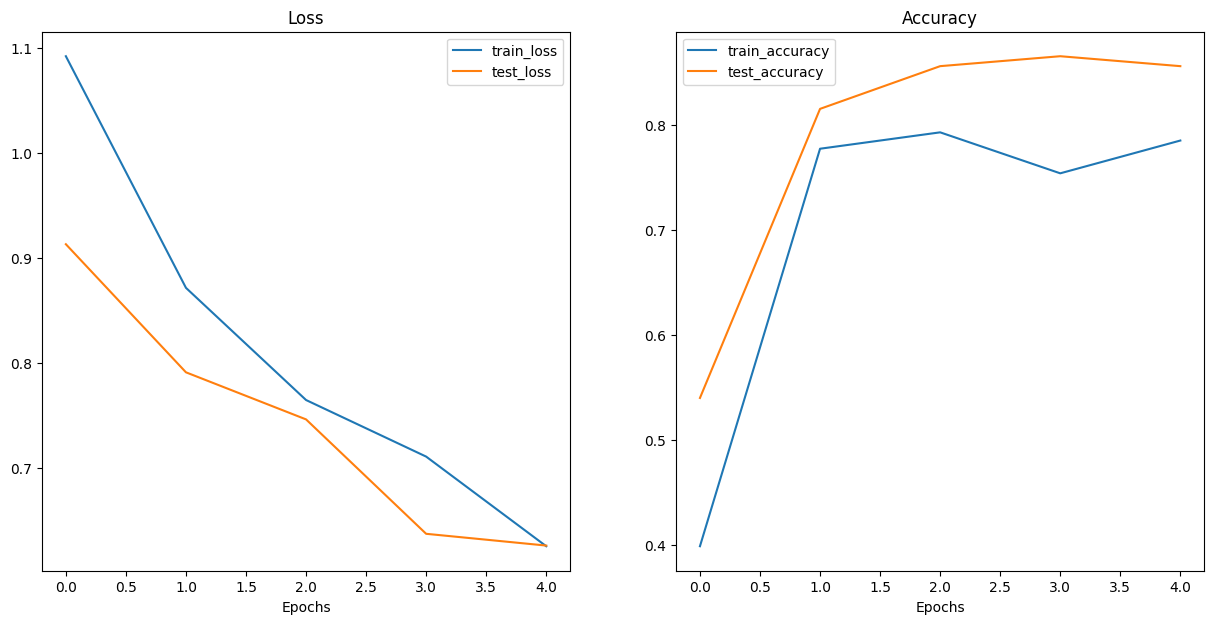

In [21]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# plot the loss curves of our model
plot_loss_curves(results)

 ## 6. Make predictions on images from the test set

 Let's adhere to the data explorer's motto of *visualize, visualize, visualize*!

 And make some qualitative predictions on our test set.

 Some things to keep in mind when making predictions/inference on test data/custom data.

 We have to make sure that our test/custom data is:
 * Same shape - images need to be same shape as model was trained on
 * Same datatype - custom data should be in the same data type
 * Same device - custom data/test data should be on the same device as the model
 * Same transform - if you have transformed your custom data, ideally you will transform the test data and custom data the same.

 To do all of this automagically, let's create a function called `pred_and_plot_image()`:

 The function will be similar to the one here: `04_pytorch_custom_datasets`

 1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device
 2. Open the image with `PIL.Image.Open()`
 3. Create a transform if one doesnot exists
 4. Make sure the model is on the target device
 5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
 6. Transform the target image and make sure its dimensionality is suited for the mdoel (this mainly relates to batch size)
 7. Make a prediction on the image by passing to the model
 8. Convert the model's output  logits to prediction probabilities using `torch.softmax()`
 9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
 10. Plot the image with `matplotlib` and set the titles to the prediction label from step 9 and prediction probability from step 8

In [30]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

# 1. Take in a trained model ...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  # 2. Open the image with PIL
  img = Image.open(image_path)

  # 3. Create a transform if one doesnot exists
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])

  # Predict on image
  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim = 0) # [batch_size, color_channels, height, width]

    # 7. Make a prediction on the transformed image by passing it to the model. (also ensure it's on the target device)
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

  # 9. Convert the prediction probabilities to prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

  # 10. Plot the image in matplotlib with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)
  plt.show()

In [31]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

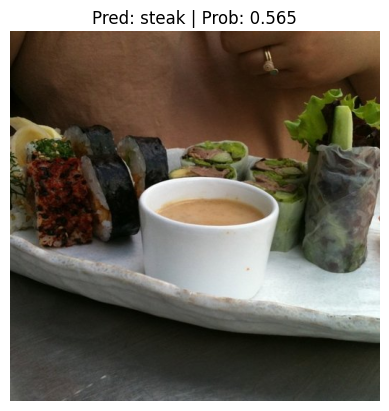

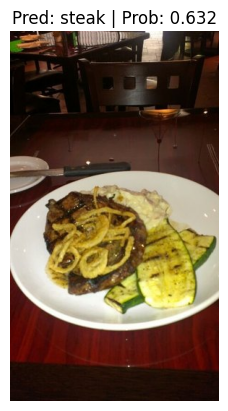

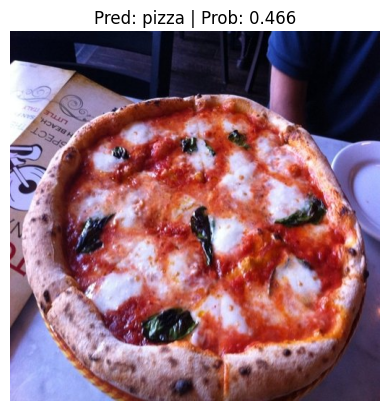

In [32]:
# Get a random list of image paths from the test set
import random

num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob(f"*/*.jpg"))
test_image_path_sample = random.sample(population = test_image_path_list,
                              k = num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model = model,
                      image_path = image_path,
                      class_names = class_names,
                      image_size = (224, 224),
                      device = device)

## 6.1 Making predictions on a custom image

Let's make a prediction on the pizza dad image: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg

In [33]:
# Download the image
import requests

# setup custom image path
custom_image_path = data_path / "04-pizza_dad.jpeg"

# Download the image if it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # Download image from GitHub with "raw" link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Download {custom_image_path}..")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

Download data/04-pizza_dad.jpeg..


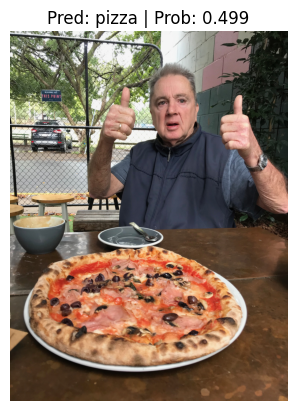

In [36]:
# Predict on custom image
pred_and_plot_image(model = model,
                    image_path = custom_image_path,
                    class_names = class_names,
                    image_size = (224, 224),
                    device = device)